# APIs and SQL Joins Lab

The city of San Francisco wants to assess the quality of restaurants in the city. Their data is scattered across multiple sources and incomplete.

They tasked you to help them assess it.

They would like to know what the most common violations are where they happen most frequently.

## 1. Initial data inspection

To answer the question we will need to retrieve and merge data from multiple files.

Yelp provides data on food quality, that can be found at [this address](http://www.yelp.com/healthscores/feeds). We already downloaded 4 files that you can find in the [assets folder](../../assets/datasets/yelp/).

In the bonus part we will also use the Google Geocoding API and data on [Neighborhoods](https://www.google.com/fusiontables/DataSource?docid=1zNwsvTwj-dH0QxuuDrKFsyfNklajd7WwEyaZ2U9M#rows:id=1).

1. Open each of the files and inspect them visually
- What information do they contain?

In [1]:
!ls ../../assets/datasets/yelp

businesses.csv  inspections.csv legend.csv      violations.csv


## 2. Local database

The first step in our analysis is to import the data into a local PostgreSQL database.

1. Launch a local Postgres server;
2. Create a local database named 'inspections';
3. Connect to it with sqlalchemy (see starter code) and import the files to separate tables.

**Note:** The files are not encoded in utf8, but in latin1. You can read more about encodings here: http://www.postgresql.org/docs/current/interactive/multibyte.html

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sqlalchemy import create_engine

engine = create_engine('postgresql://student@localhost:5432/inspections') # Replace 'winston' with your username

In [3]:
def load_to_sql(name):
    df = pd.read_csv('../../assets/datasets/yelp/{}.csv'.format(name), encoding='latin1')
    df.to_sql(name, engine, flavor='postgres', if_exists='replace')
    print "done", name
    
load_to_sql('businesses')
load_to_sql('inspections')
load_to_sql('legend')
load_to_sql('violations')

done businesses
done inspections
done legend
done violations


### 2.b Display the first few lines of each table

In [4]:
# Replace <user> with your user name

%load_ext sql
%sql postgresql://student@localhost:5432/inspections

u'Connected: student@inspections'

In [5]:
%%sql
select * from inspections limit 2;

2 rows affected.


index,business_id,score,date,type
0,10,94,20140729,routine
1,10,92,20140114,routine


In [6]:
%%sql
select * from businesses limit 2;

2 rows affected.


index,business_id,name,address,city,state,postal_code,latitude,longitude,phone_number
0,10,TIRAMISU KITCHEN,033 BELDEN PL,San Francisco,CA,94104,37.791116,-122.403816,+14154217044
1,19,NRGIZE LIFESTYLE CAFE,"1200 VAN NESS AVE, 3RD FLOOR",San Francisco,CA,94109,37.786848,-122.421547,+14157763262


In [7]:
%%sql
select * from legend limit 2;

2 rows affected.


index,Minimum_Score,Maximum_Score,Description
0,0,70,Poor
1,71,85,Needs Improvement


In [8]:
%%sql
select * from violations limit 2;

2 rows affected.


index,business_id,date,description
0,10,20140729,Insufficient hot water or running water [ date violation corrected: 8/7/2014 ]
1,10,20140729,Unapproved or unmaintained equipment or utensils [ date violation corrected: 8/7/2014 ]


In [9]:
%%sql
select * from information_schema.tables limit 2;

2 rows affected.


table_catalog,table_schema,table_name,table_type,self_referencing_column_name,reference_generation,user_defined_type_catalog,user_defined_type_schema,user_defined_type_name,is_insertable_into,is_typed,commit_action
inspections,pg_catalog,pg_statistic,BASE TABLE,None,None,None,None,None,YES,NO,None
inspections,pg_catalog,pg_type,BASE TABLE,None,None,None,None,None,YES,NO,None


## 2.b Investigate violations

Let's focus on the violations table initially.


Answer these questions using sql:
1. How many violations are there?
- How many businesses committing violations?
- What's the average number of violations per business?

Answer these questions using python
1. Draw a plot of the violations count
- Is the average number of violations meaningful?
- Draw a plot of the normalized cumulative violation counts. Can we discard the restaurants with few violations?
- Where would you draw a threshold if you were to keep 90% of the violations?

In [10]:
%%sql
select count(*) from violations;

1 rows affected.


count
39917


In [11]:
%%sql
select count(distinct business_id) from violations;

1 rows affected.


count
5022


In [12]:
%%sql
select avg(c) from (select distinct business_id, count(*) as c from violations 
group by business_id) as count;


1 rows affected.


avg
7.9484269215452011


In [13]:
v = %%sql select business_id, count(*) as count from violations group by business_id order by count desc;

5022 rows affected.


In [14]:
v = v.DataFrame()

In [15]:
v['count'].mode()

0    2
dtype: int64

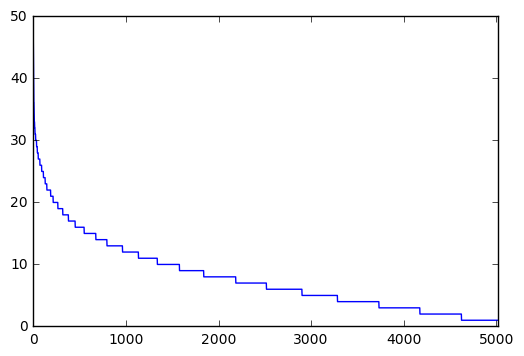

In [16]:
v['count'].plot()

In [17]:
import numpy as np
from scipy import stats

> The average is not meaningful because it doesn't reveal many companies with only 1 violation as a result of a skew in the data from outliers who have many violations. The mode would be a better aggregation of "average"

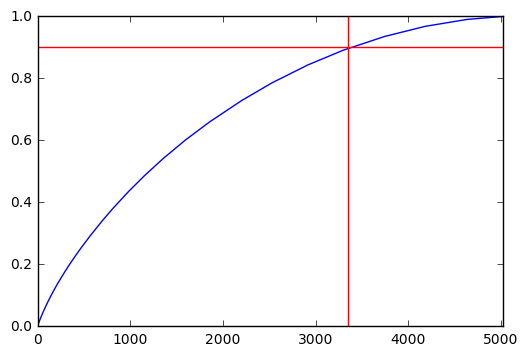

In [26]:
(v['count'].cumsum()/v['count'].sum()).plot()
plt.axhline(0.9, color = 'r')
plt.axvline(3350, color = 'r')

In [47]:
v.iloc[3350,:]

business_id    39052
count              4
Name: 3350, dtype: int64

> The threshold will be at 4 violations if we kept it at 90% of the violations

### 2.c Investigate Inspections

In the previous step we looked at violations count. However we also have an inspection score available in the inspections table. Let's have a look at that too.

Answer these questions using SQL:
1. What's the average score for the whole city?
1. What's the average score per business?
- Does the score correlate with the number of inspections?
- Create a dataframe from a table with the following columns:
    business_id, average_score, number_of_inspections, number_of_violations
- Use pandas to do a scatter matrix plot of average_score, number_of_inspections, number_of_violations to check for correlations

In [37]:
%%sql
select avg(score) from inspections;

1 rows affected.


avg
91.4672412675782516


In [60]:
%%sql 
select business_id, avg(score) from inspections 
group by business_id
order by avg(score) asc;


5513 rows affected.


business_id,avg
18480,50.5000000000000000
60469,55.0000000000000000
82134,55.0000000000000000
1207,56.0000000000000000
80591,57.0000000000000000
83799,59.0000000000000000
71071,59.0000000000000000
74522,59.5000000000000000
1750,60.0000000000000000
69962,61.5000000000000000


In [66]:
%%sql 
select business_id, count(*) from inspections
group by business_id order by count(*) desc;

5513 rows affected.


business_id,count
66328,8
5791,8
5297,8
5790,7
5499,7
5628,7
65893,7
5461,7
5497,7
5471,7


In [79]:
s = %sql select a.business_id, average_score, \
number_of_inspections, number_of_violations \
from (select business_id, avg(score) as average_score, count(*) as number_of_inspections from inspections \
group by business_id) as a \
join (select business_id, count(*) as number_of_violations from violations group by business_id) as b \
on a.business_id = b.business_id;

4995 rows affected.


In [94]:
s = s.DataFrame()

In [96]:
s.head()

,business_id,average_score,number_of_inspections,number_of_violations
0,10,93.0000000000000000,2,5
1,19,94.6666666666666667,3,5
2,24,97.0000000000000000,4,5
3,31,99.0000000000000000,2,1
4,45,88.6666666666666667,3,12


In [105]:
s['average_score'] = s['average_score'].apply(float)

In [106]:
import seaborn as sns

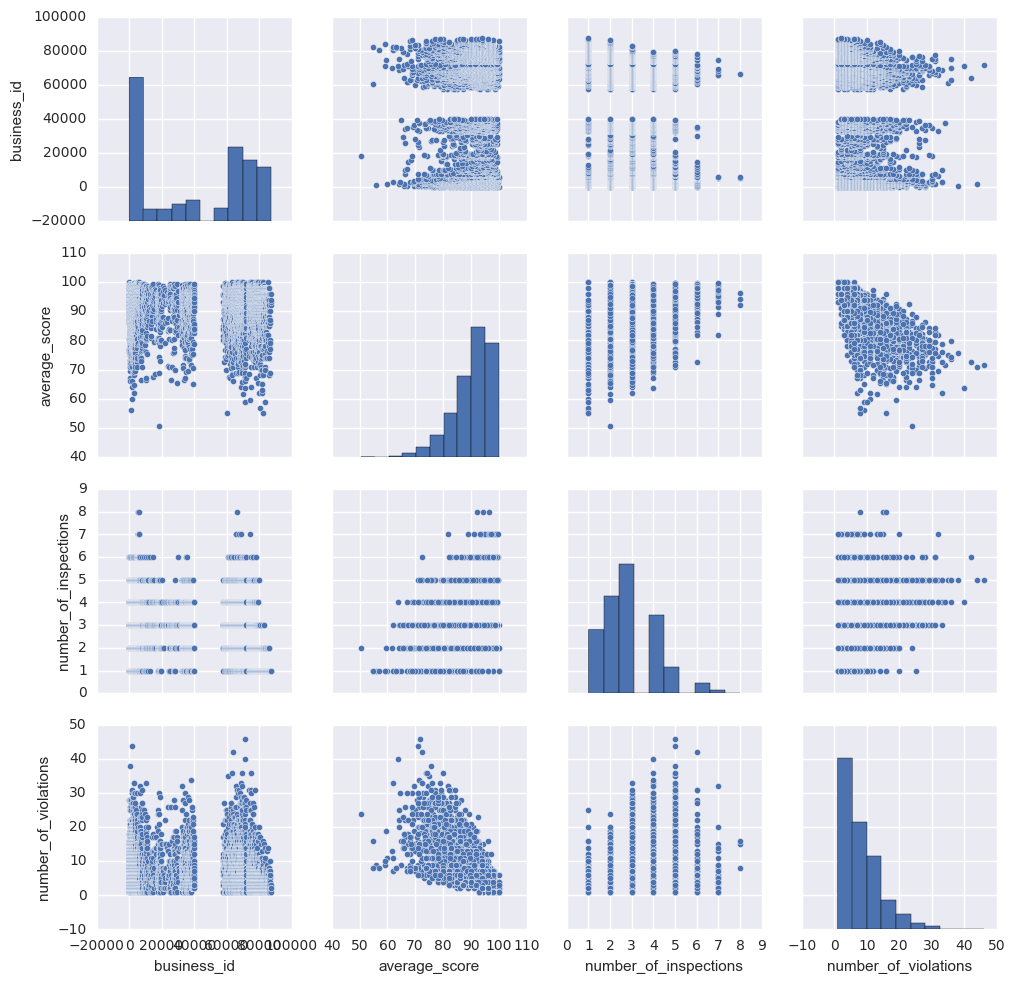

In [107]:
sns.pairplot(s)

In [108]:
from pandas.tools.plotting import scatter_matrix

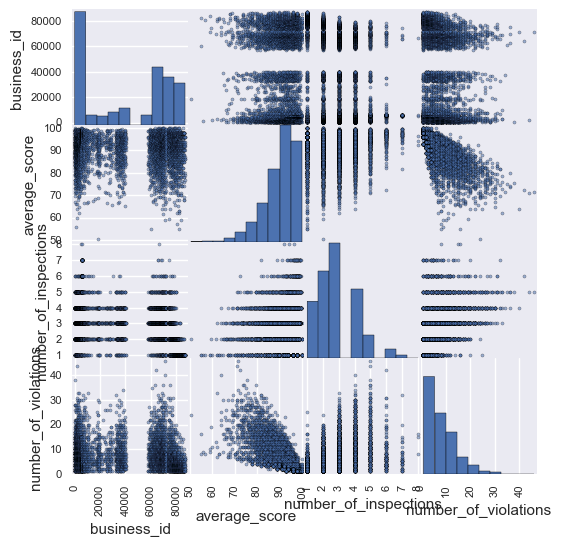

In [111]:
scatter_matrix(s, figsize=(6, 6));

## 3 Zipcode analysis

The town administration would like to know which zip code are the ones where they should focus the inspections.

Use the information contained in the `businesses` table as well as the previous tables to answer the following questions using SQL:

1. Count the number of businesses per zipcode and sort them by descending order
- Which are the top 5 zipcodes with the worst average score?
    - restrict your analysis to the zipcodes with at least 50 businesses
    - do a simple average of the inspections scores in the postal code
- Which are the top 5 zipcodes with the highest number of violations per restaurant?
    - restrict your  analysis to the zipcodes with at least 50 businesses


In [120]:
%%sql
select postal_code, count(business_id) 
from businesses
group by postal_code
order by count(business_id) desc limit 10;

10 rows affected.


postal_code,count
94110,559
94103,552
94102,447
94107,429
94133,425
94109,374
94111,280
94122,258
94118,244
None,240


In [136]:
%%sql
select postal_code, avg(score)
from businesses b join inspections i on b.business_id = i.business_id
group by postal_code
having count(b.business_id) > 50 
order by avg(score) asc limit 5;

5 rows affected.


postal_code,avg
94133,87.4457142857142857
94122,87.6196319018404908
94109,89.1738241308793456
94108,89.8853974121996303
94127,90.2487046632124352


In [145]:
%%sql
select postal_code, count(v.business_id)/count(distinct v.business_id) as violation_restaurant 
from businesses b join violations v on b.business_id = v.business_id
group by postal_code
having count(b.business_id) > 50 
order by violation_restaurant desc limit 5;


5 rows affected.


postal_code,violation_restaurant
94133,10
94122,10
94114,9
94109,9
94127,9


## Final recommendation
Give a final recommendation on which 2 zipcodes should the administration focus and choose an appropriate plot to convince them visually.

## Bonus: Neighborhood data

Instead of looking at zipcodes we may be interested in using Neighborhood names.

It's beyond the scope of this lab to do a proper introduction to Geocoding and Reverse Geocoding, but we will give some pointers for further exploration.

### 1. Google Geocoding API
Have a look at:
- https://developers.google.com/maps/documentation/geocoding/intro
- https://maps.googleapis.com/maps/api/geocode/json?address=
- https://maps.googleapis.com/maps/api/geocode/json?latlng=

Through this API you can retrieve an address or a neighborhood from a lat-lon pair (reverse geocoding), or you can retrieve lat long and other information from an address (geocoding).

1. Try experimenting with and retrieving a few addresses
- Note that google imposes limits on the number of free queries
- How many missing lat-lon pairs do we have?

### Bonus 2
The pycurl library seems to be faster than requests in getting information from the google api.

1. See if you can extract the neighborhood from an address using the geocode api and a bit of json parsing
- Note that you would surely hit the daily limit if you pulled each address' neighborhood from the api

### Bonus 3
We can find the neighborhood using the polygons associated to each of them.
[Here](https://www.google.com/fusiontables/DataSource?docid=1zNwsvTwj-dH0QxuuDrKFsyfNklajd7WwEyaZ2U9M#rows:id=1) you can find these polygons (and we also copied them [locally](../../assets/datasets/sfneighborhoods.csv).

[This article](http://streamhacker.com/2010/03/23/python-point-in-polygon-shapely/) describes how to use the shapely package to check if a point belongs to a polygon.

- See if you can build a function that retrieves the neighborhood for a given address using the polygon data

### Further exploration

Postgres is actually GIS enabled, so we could do location based queries directly in the database.

Have a look at http://postgis.refractions.net/ for more information.